# Image classification from scratch

In this notebook, a neural network is being implemented to classify images from CIFAR-10

In [1]:
# Let's import all required libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Import data

In [2]:
# loading the cifar10 dataset
from keras.datasets import cifar10
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [3]:
# Check the data
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of X_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


In [4]:
y_train[:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

In [5]:
# Get no. of unique classes
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Hence, there are 10 unique classes in the dataset.

0: airplane,
1: automobile,
2: bird,
3: cat,
4: deer,
5: dog,
6: frog,
7: horse,
8: ship,
9: truck

## Data visualization

In [6]:
# Let's map label numbers with their names
def get_label_names(label_num):
  label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
  }

  if isinstance(label_num, np.ndarray):
        label_num = label_num.item()
  return label_map.get(label_num)

In [7]:
import random

def view_random_images(n=3):

  # This function will show you n random images from X_train dataset
    import numpy as np
    import matplotlib.pyplot as plt

    # Generate n random indices
    indices = np.random.randint(0, len(X_train), size=n)

    plt.figure(figsize=(n * 3, 3))  # Adjust figure size as needed

    for i, idx in enumerate(indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(X_train[idx])
        plt.title(get_label_names(y_train[idx]))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

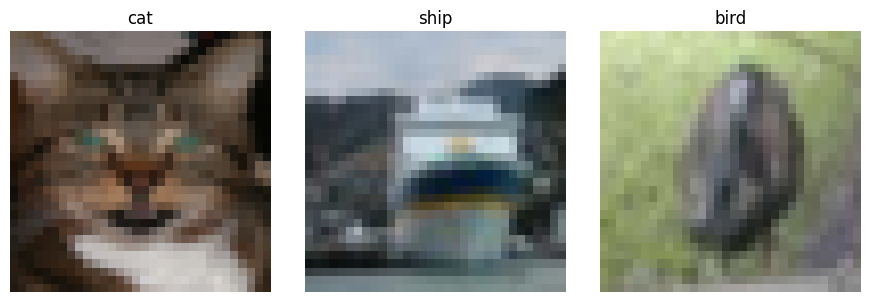

In [8]:
view_random_images()

In [9]:
print(X_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


## Data processing

In [10]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape)
print(y_train.shape)

# Convert labels into 1D.
y_train = y_train.flatten()
y_test = y_test.flatten()

(50000, 32, 32, 3)
(50000, 1)


The provided problem statement requires to work on only 3 classes.

We are choosing first three classes.

In [11]:
# Choose classes to keep
selected_classes = [0, 1, 2]  # for example

# Create mask based on labels
train_mask = np.isin(y_train, selected_classes)
test_mask = np.isin(y_test, selected_classes)

In [12]:
# After filtering by class
X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]
X_test_filtered = X_test[test_mask]
y_test_filtered = y_test[test_mask]

# Flatten filtered image data
X_train_flat = X_train_filtered.reshape(X_train_filtered.shape[0], -1).T  # (3072, N_train)
X_test_flat = X_test_filtered.reshape(X_test_filtered.shape[0], -1).T     # (3072, N_test)

# Confirm label alignment
print(X_train_flat.shape)        # (3072, N)
print(y_train_filtered.shape)    # (N,)
print(X_test_flat.shape)         # (3072, M)
print(y_test_filtered.shape)     # (M,)


(3072, 15000)
(15000,)
(3072, 3000)
(3000,)


In [13]:
# Normalise our images
X_train = X_train_flat/ 255.
X_test = X_test_flat/ 255.

In [14]:
# Check shape of all datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3072, 15000)
(50000,)
(3072, 3000)
(10000,)


In [15]:
# See number of classes in label
np.unique(y_train_filtered)

array([0, 1, 2], dtype=uint8)

## Build model

In [16]:
def init_params():
  # Defining weights and biases
    W1 = np.random.randn(128, 3072) * 0.01  # 128 hidden units
    b1 = np.zeros((128, 1))
    W2 = np.random.randn(3, 128) * 0.01
    b2 = np.zeros((3, 1))
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1         # (128, 15000)
    A1 = ReLU(Z1)               # (128, 15000)
    Z2 = W2.dot(A1) + b2        # (10, 15000)
    A2 = softmax(Z2)            # (10, 15000)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y, num_classes):
    one_hot_Y = np.zeros((num_classes, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, num_classes, lambd=0.01):
    m = X.shape[1]
    one_hot_Y = one_hot(Y, num_classes)

    dZ2 = A2 - one_hot_Y
    dW2 = (1 / m) * dZ2.dot(A1.T) + (lambd / m) * W2
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = (1 / m) * dZ1.dot(X.T) + (lambd / m) * W1
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
  # Updates parameters to make model better
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [17]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def compute_loss(A2, Y, num_classes, lambd, W1, W2):
    m = Y.size
    one_hot_Y = one_hot(Y, num_classes)
    # Clip values to avoid log(0)
    log_probs = np.log(A2 + 1e-9)
    cross_entropy_loss = -np.sum(one_hot_Y * log_probs) / m

    # L2 regularization term
    L2_term = (lambd / (2 * m)) * (np.sum(np.square(W1)) + np.sum(np.square(W2)))

    loss = cross_entropy_loss + L2_term
    return loss

def gradient_descent(X, Y, alpha, iterations, lambd=0.01):
    num_classes = len(np.unique(Y))
    W1, b1, W2, b2 = init_params()
    losses = []
    accuracies = []

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        loss = compute_loss(A2, Y, num_classes, lambd, W1, W2)
        losses.append(loss)

        predictions = get_predictions(A2)
        accuracy = get_accuracy(predictions, Y)
        accuracies.append(accuracy)

        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, num_classes, lambd)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        if i % 10 == 0:
            print(f"Iteration: {i}, Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%")

    return W1, b1, W2, b2, losses, accuracies

In [18]:
W1, b1, W2, b2, losses, accuracies = gradient_descent(X_train, y_train_filtered, alpha=0.1, iterations=500)

Iteration: 0, Loss: 1.1007, Accuracy: 25.84%
Iteration: 10, Loss: 1.0709, Accuracy: 35.64%
Iteration: 20, Loss: 1.0093, Accuracy: 57.92%
Iteration: 30, Loss: 1.4110, Accuracy: 34.16%
Iteration: 40, Loss: 0.9978, Accuracy: 54.41%
Iteration: 50, Loss: 1.0532, Accuracy: 57.19%
Iteration: 60, Loss: 0.9903, Accuracy: 56.57%
Iteration: 70, Loss: 1.0307, Accuracy: 39.88%
Iteration: 80, Loss: 1.0913, Accuracy: 50.88%
Iteration: 90, Loss: 0.9934, Accuracy: 51.89%
Iteration: 100, Loss: 1.0115, Accuracy: 45.35%
Iteration: 110, Loss: 1.0880, Accuracy: 36.43%
Iteration: 120, Loss: 0.9436, Accuracy: 56.48%
Iteration: 130, Loss: 0.9476, Accuracy: 63.56%
Iteration: 140, Loss: 1.0194, Accuracy: 43.87%
Iteration: 150, Loss: 0.9636, Accuracy: 58.75%
Iteration: 160, Loss: 0.9980, Accuracy: 49.83%
Iteration: 170, Loss: 1.1719, Accuracy: 41.71%
Iteration: 180, Loss: 0.8844, Accuracy: 66.05%
Iteration: 190, Loss: 0.9266, Accuracy: 58.54%
Iteration: 200, Loss: 0.9153, Accuracy: 60.49%
Iteration: 210, Loss: 0.

## Evaluation

In [19]:
# Get prediction on test data
_, _, _, A2_test = forward_prop(W1, b1, W2, b2, X_test_flat)
test_predictions = get_predictions(A2_test)

<ipython-input-16-95361c8eb81f>:13: RuntimeWarning: overflow encountered in exp
  A = np.exp(Z) / sum(np.exp(Z))
<ipython-input-16-95361c8eb81f>:13: RuntimeWarning: invalid value encountered in divide
  A = np.exp(Z) / sum(np.exp(Z))


In [20]:
# Check the accuracy of model on test data
accuracy = get_accuracy(test_predictions, y_test_filtered)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 64.43%


WOAH! We have 64.43% accuracy. 👏👏👏

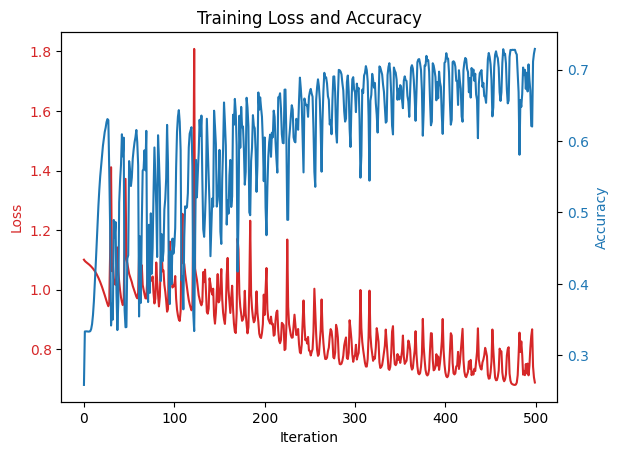

In [21]:
# Plot loss and accuracy curve
fig, ax1 = plt.subplots()
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(losses, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(accuracies, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Training Loss and Accuracy')
plt.show()

In [22]:
# Print evaluation metrics
print("Classification Report:\n")
print(classification_report(y_test_filtered, test_predictions, target_names=[f"Class {i}" for i in np.unique(y_test_filtered)]))

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.52      0.89      0.66      1000
     Class 1       0.81      0.60      0.69      1000
     Class 2       0.82      0.44      0.57      1000

    accuracy                           0.64      3000
   macro avg       0.72      0.64      0.64      3000
weighted avg       0.72      0.64      0.64      3000



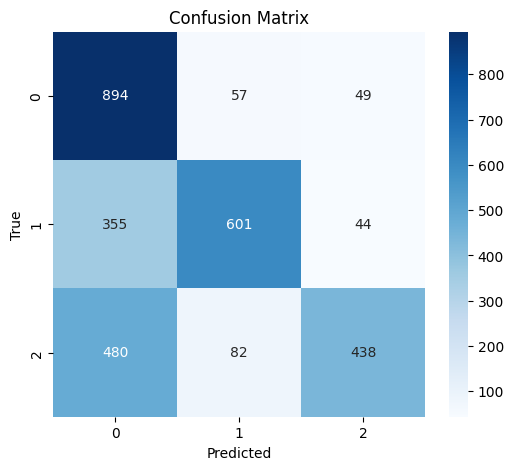

In [23]:
# Plot confusion matrix
cm = confusion_matrix(y_test_filtered, test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_filtered), yticklabels=np.unique(y_test_filtered))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Save model

In [24]:
def save_model(filename, W1, b1, W2, b2):
    np.savez_compressed(filename, W1=W1, b1=b1, W2=W2, b2=b2)

def load_model(filename):
    model = np.load(filename)
    return model["W1"], model["b1"], model["W2"], model["b2"]

In [25]:
save_model("my_cnn_weights.npz", W1, b1, W2, b2)

In [ ]:
# load the model
W1, b1, W2, b2 = load_model("my_cnn_weights.npz")